# A2 Solution 

## Xiqiao Xie 

## 1002905118

The Goal of this assignment is to get you familiar with the basics of Bayesian inference in large models with continuous latent variables, and the basics of stochastic variational inference.

## 1. Implementing the model

(a) Implement a function `log_prior` that computes the log of the prior over all player's skills.

In [4]:
function log_prior(zs)  # joint log-likelihood for prior distributions
  N,K  = size(zs)
  μ = zeros(1, K)
  σ = ones(1, K)
  log_pr = factorized_gaussian_log_density(μ, log.(σ), zs)
  return  log_pr
end;

(b) Implement a function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$ evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

In [5]:
function logp_a_beats_b(za,zb)  # za and zb can be arrays
  y = za .- zb
  lklhd = -log1pexp.(-(y))
  return (lklhd)
end;

(c) Assuming all game outcomes are i.i.d. conditioned on all players' skills, implement a function `all_games_log_likelihood` that takes a batch of player skills `zs` and a collection of observed games and gives a batch of log-likelihoods for those observations.

In [6]:
function all_games_log_likelihood(zs,games)  # zs = N*K, games = M*2
  winners = games[ : , 1]  # M*1
  losers = games[ : , 2]   # M*1
  zs_a = zs[winners, : ]   # winners skills, M*K
  zs_b = zs[losers, : ]  #losers skills, M*K
  likelihoods = logp_a_beats_b(zs_a, zs_b)  # M*K
  return  sum(likelihoods, dims = 1)  # a 1*K matrix
end;

(d) Implement a function `joint_log_density` which combines the log-prior and log-likelihood of the observations to give $p(z_1, z_2, ..., z_N,$ all game outcome$)$.

In [7]:
function joint_log_density(zs,games)
  return log_prior(zs) .+ all_games_log_likelihood(zs,games)  # K*1
end;

In [8]:
@testset "Test shapes of batches for likelihoods" begin
  B = 15 # number of elements in batch ; K
  N = 4 # Total Number of Players
  test_zs = randn(4,15)
  test_games = [1 2; 3 1; 4 2] # 1 beat 2, 3 beat 1, 4 beat 2
  @test size(test_zs) == (N,B)
  #batch of priors
  @test size(log_prior(test_zs)) == (1,B)
  # loglikelihood of p1 beat p2 for first sample in batch
  @test size(logp_a_beats_b(test_zs[1,1],test_zs[2,1])) == ()
  # loglikelihood of p1 beat p2 broadcasted over whole batch
  @test size(logp_a_beats_b.(test_zs[1,:],test_zs[2,:])) == (B,)
  # batch loglikelihood for evidence
  @test size(all_games_log_likelihood(test_zs,test_games)) == (1,B)
  # batch loglikelihood under joint of evidence and prior
  @test size(joint_log_density(test_zs,test_games)) == (1,B)
end

Test Summary:                          | Pass  Total
Test shapes of batches for likelihoods |    6      6


Test.DefaultTestSet("Test shapes of batches for likelihoods", Any[], 6, false)

## 2. Examing the posterior for only two players and toy data

(a) For two players A and B, plot the isocontours of the joint prior over their skills. Also plot the line of equal skill, $z_A = z_B$.

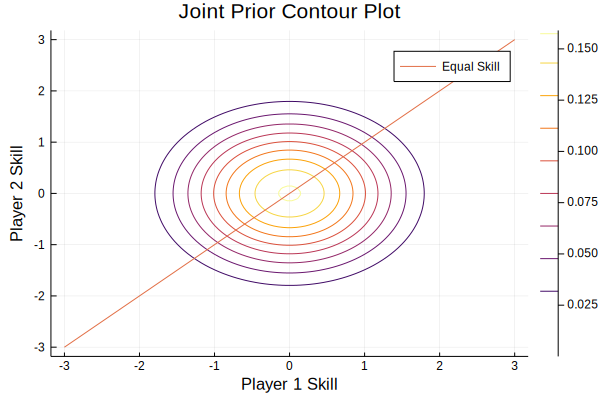

In [9]:
# Convenience function for producing toy games between two players.
two_player_toy_games(p1_wins, p2_wins) = vcat([repeat([1,2]',p1_wins), repeat([2,1]',p2_wins)]...)

# plot prior contours
plot(title="Joint Prior Contour Plot",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill"
   )
joint_prior(zs) = exp(log_prior(zs))
skillcontour!(joint_prior)
plot_line_equal_skill!()

(b) Plot the isocontours of the likelihood function. Also plot the line of equal skill, $z_A = z_b$.

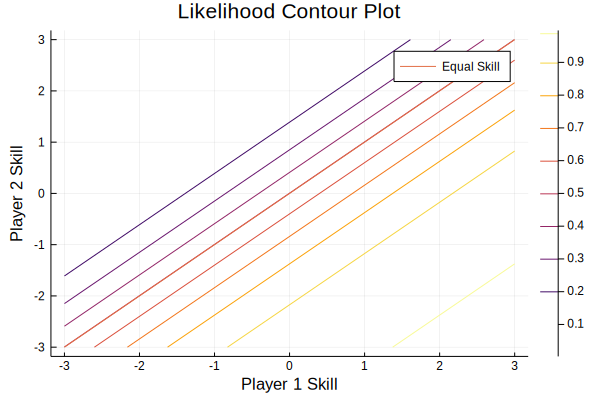

In [10]:
# plot likelihood contours
plot(title="Likelihood Contour Plot",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill"
   )
likelihood(za, zb) = exp.(logp_a_beats_b(za,zb) )  # likelihood of za beats zb
#fixed_games = two_player_toy_games(90, 20)
h(z) = likelihood(z[1], z[2])
skillcontour!(h)
plot_line_equal_skill!()

(c) Plot isocontours of the joint posterior over $z_A$ and $z_B$ given that player A beat player B in one match. Since the contours don't depend on the normalization constant, you can simply plot the isocontours of the log of joint distribution of $p(z_A, z_B,$ A beat B$)$. Also plot the line of equal skill.

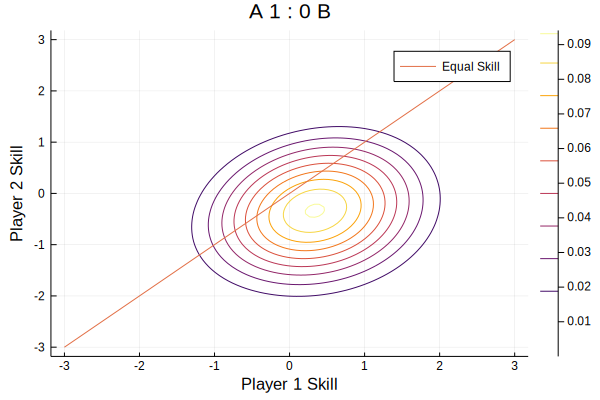

In [11]:
# plot joint contours with player A winning 1 game
plot(title="A 1 : 0 B",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill"
   )
joint_posterior_1(zs, games) = exp.(joint_log_density(zs,games)) # joint posterior
fixed_games = two_player_toy_games(1, 0)
h(zs) = joint_posterior_1(zs, fixed_games)
skillcontour!(h)
plot_line_equal_skill!()

(d) Plot the isocontours of the joint posterior over $z_A$ and $z_B$ given that 10 matches werr played, and player A beat player B all 10 times. Also plot the line of equal skill.

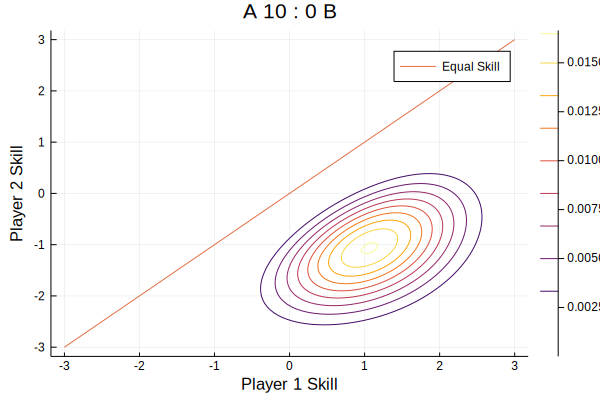

In [12]:
#  plot joint contours with player A winning 10 games
plot(title="A 10 : 0 B",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill"
   )
joint_posterior_2(zs, games) = exp.(joint_log_density(zs,games)) # joint posterior
fixed_games = two_player_toy_games(10, 0)
h(zs) = joint_posterior_2(zs, fixed_games)
skillcontour!(h)
plot_line_equal_skill!()

(e) Plot the isocontours of the joint posterior over $z_A$ and $z_B$ given that 20 matches were played and each player beat the other 10 times. Also plot the line of equal skill.

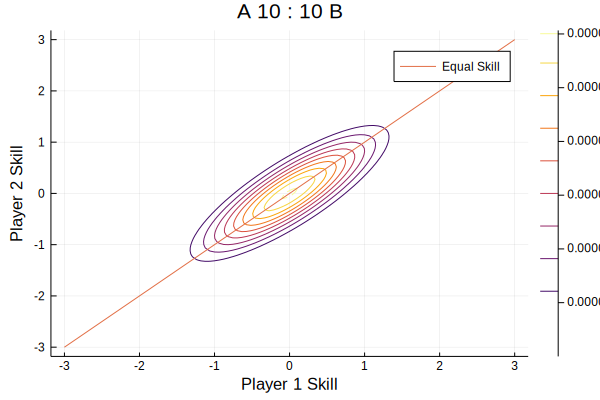

In [13]:
#plot joint contours with player A winning 10 games and player B winning 10 games

plot(title="A 10 : 10 B",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill"
   )
joint_posterior_3(zs, games) = exp.(joint_log_density(zs,games)) # joint posterior
fixed_games = two_player_toy_games(10, 10)
h(zs) = joint_posterior_3(zs, fixed_games)
skillcontour!(h)
plot_line_equal_skill!()

## 3. Stochastic variational inference on tow players and toy data

**(a)** Implement a function `elbo` which computes an unbiased estimate of the evidence lower bound.

In [14]:
function elbo(params,logp,num_samples)  #params:2*N (μ, logσ) ; logp is a function
  μ = params[1][:]
  σ = exp.(params[2])[:]
  N = length(μ)
  ϵ = randn(N, num_samples)  # N*B
  samples = σ .* ϵ .+ μ  # N*B
  logp_estimate = logp(samples)
  logq_estimate = factorized_gaussian_log_density(μ, log.(σ), samples)
  return mean(logp_estimate .- logq_estimate) #scalar (hint: average over batch)
end;

**(b)** Write a loss function called `neg_toy_elbo` that takes variational distribution parameters and an array of game outcomes, and returns the negative estimate with 100 samples.

In [15]:
# Conveinence function for taking gradients
function neg_toy_elbo(params; games = two_player_toy_games(1,0), num_samples = 100)
  # Write a function that takes parameters for q,
  # evidence as an array of game outcomes,
  # and returns the -elbo estimate with num_samples many samples from q
  logp(zs) = joint_log_density(zs,games)
  return -elbo(params,logp, num_samples)
    end;

**(c)** Write an optimization function called `fit_toy_variational_dist` which takes initial variational parameters, and the evidence. 

In [16]:
# Toy game
num_players_toy = 2
toy_mu = [-2.,3.] # Initial mu, can initialize randomly!
toy_ls = [0.5,0.] # Initual log_sigma, can initialize randomly!
toy_params_init = [toy_mu, toy_ls]


2-element Array{Array{Float64,1},1}:
 [-2.0, 3.0]
 [0.5, 0.0] 

In [17]:
function fit_toy_variational_dist(init_params, toy_evidence; num_itrs=200, lr= 1e-2, num_q_samples = 10)
  params_cur = init_params
  for i in 1:num_itrs
    grad_params = gradient(params -> neg_toy_elbo(params; games = toy_evidence,
                      num_samples = num_q_samples), params_cur)# gradients of variational objective with respect to parameters
    params_cur =  params_cur .- lr .* grad_params[1] #update paramters with lr-sized step in descending gradient
    #@info "Current elbo" -neg_toy_elbo(params_cur; games = toy_evidence, num_samples = num_q_samples)
    μ = params_cur[1]
    σ = exp.(params_cur[2])
    #N = length(μ)
    #ϵ = randn(N, num_q_samples)  # N*B
    #samples = σ .* ϵ + μ  # N*B
    p_estimate(zs) = exp.(joint_log_density(zs, toy_evidence))
    q_estimate(zs) = exp.(factorized_gaussian_log_density(μ, log.(σ), zs))
    plot(title="Target vs Variational Posterior",
        xlabel = "Player 1 Skill",
        ylabel = "Player 2 Skill");
    skillcontour!(p_estimate; colour =:red)  # likelihood contours for target posterior
    plot_line_equal_skill!()
    (skillcontour!(q_estimate ; colour =:blue)) #likelihood contours for variational posterior
  end
  savefig(joinpath("plots","Tar_var_10_10.png"))
  print("final negative ELBO = ", neg_toy_elbo(params_cur; games = toy_evidence, num_samples = num_q_samples))
  return params_cur
end


fit_toy_variational_dist (generic function with 1 method)

**(d)** Initialize a variational distribution parameters and optimize them to approximate the joint where we observe player A winning 1 game. Report the final loss. Also plot the optimized variantional approximation contours (in blue) and the target distribution (in red) on the same axes.

In [172]:
## Player A winning 1 game
toy_evid_1 = two_player_toy_games(1,0)
fit_toy_variational_dist(toy_params_init, toy_evid_1);

final negative ELBO = 0.8041367478714803

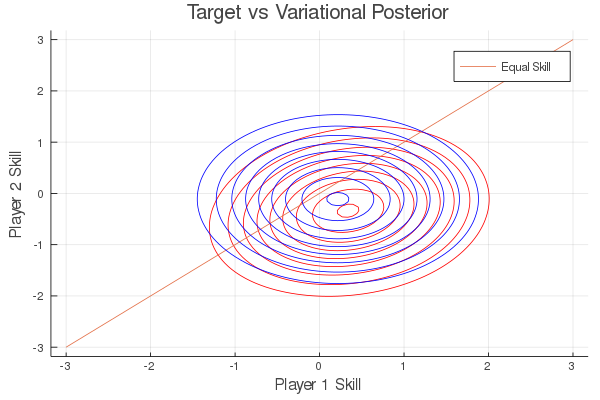

**(e)** Initialize a variational distribution parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variantional approximation contours (in blue) and the target distribution (in red) on the same axes.

In [174]:
## Player A winning 10 gmaes
toy_evid_2 = two_player_toy_games(10,0)
fit_toy_variational_dist(toy_params_init, toy_evid_2);

final negative ELBO = 2.844656539365144

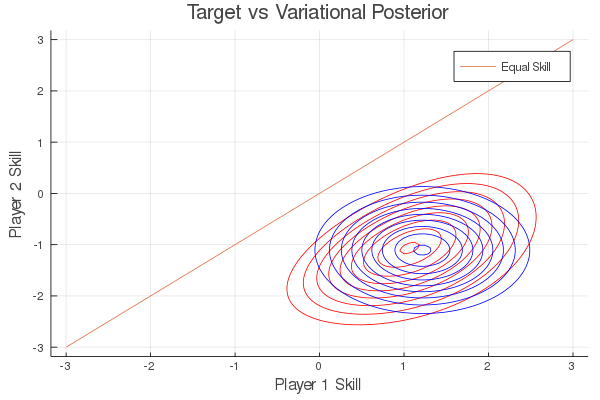

**(f)** Initialize a variational distribution parameters and optimize them to approximate the joint where we observe player A winning 1o game and player B winning 10 games. Report the final loss. Also plot the optimized variantional approximation contours (in blue) and the target distribution (in red) on the same axes.

In [177]:
## Player A and B each win 10 games
toy_evid_3 = two_player_toy_games(10,10)
fit_toy_variational_dist(toy_params_init, toy_evid_3);

final negative ELBO = 15.568181235775537

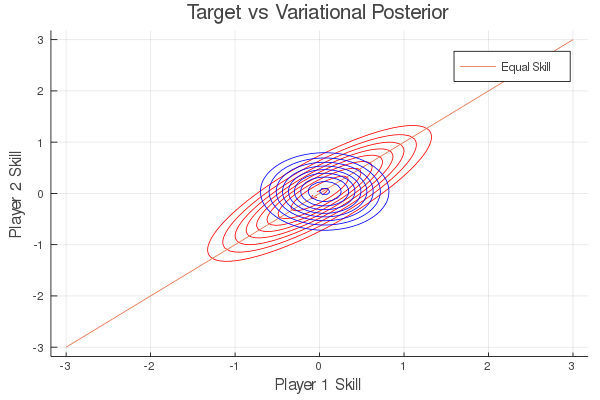

## 4. Approximate inference conditioned on real data 

Load the dataset from `tennis_data.mat` containing two matrices:
* W is a 107 by 1 matrix, whose $i'$th entry is the name if player $i$.
* G is a 1801 by 2 matrix of game outcomes (actually tennis matches), one row per game. The first column contains the indices of the players who won. The second column contains the indices of the player who lost. 
    Compute the following using your code from the earlier questions in the assignment, but conditioning on the tennis match outcomes. 

**(a)** For any two players $i$ and $j$, $p(z_i, z_j|$ all games$)$ is always propotional to $p(z_i, z_j,$ all games$)$. In general, do the games between other players besides $i$ and $j$ provide informtion about the skill of players $i$and $j$? A simple yes or no suffice. 

**Answer:** The isocontours of $p(z_i,z_j|$ all games$)$ is not the same as those of $p(z_i, z_j|$ games between i and j$)$. In other words, games between other players besides $i$ and $j$ DO provide information about the skills of $i$ and $j$. All the games that either player $i$ or $j$ participates will provide information about these two players. 

**(b)** Write a new optimization function `fit_variational_dist` like the one from the previous question except it does not plot anything. Initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset. Report the final negative ELBO estimate after optimization.

In [20]:
#using MAT
vars = matread("tennis_data.mat")
player_names = vars["W"]
tennis_games = Int.(vars["G"])
num_players = length(player_names)
print("Loaded data for $num_players players")

Loaded data for 107 players

In [21]:
# b. write a new function.

function fit_variational_dist(init_params, tennis_games; num_itrs = 200, lr = 1e-2, num_q_samples = 10)
    params_cur = init_params
    for i in 1:num_itrs
        grad_params = gradient(params -> neg_toy_elbo(params; games = tennis_games, 
                                num_samples = num_q_samples), params_cur)
        params_cur = params_cur .- lr .* grad_params[1]
        #@info "Current Elbo" -neg_toy_elbo(params_cur; games = tennis_games, num_samples = num_q_samples)
        #@info "current parameters" params_cur
    end
    print("Final Neg ELBO = ", neg_toy_elbo(params_cur; games = tennis_games, num_samples = num_q_samples))
    return params_cur
end     

fit_variational_dist (generic function with 1 method)

**(c)** Plot the approximate mean and variance of all players, sorted by skill. For example, in Julia, you can use `perm = sortperm(means); plot(means[perm], yerror = exp.(logstd[perm]))`. There's no need to include names of the players. 

In [22]:
#initialize parameters 
tennis_μ = randn(1, num_players)
tennis_σ = ones(1, num_players)
tennis_params_init = [tennis_μ , log.(tennis_σ)]

2-element Array{Array{Float64,2},1}:
 [0.8790614277386386 -0.25625046640669824 … -0.7208875721134679 -0.08818765083089511]
 [0.0 0.0 … 0.0 0.0]                                                                 

Final Neg ELBO = 1143.473453441925

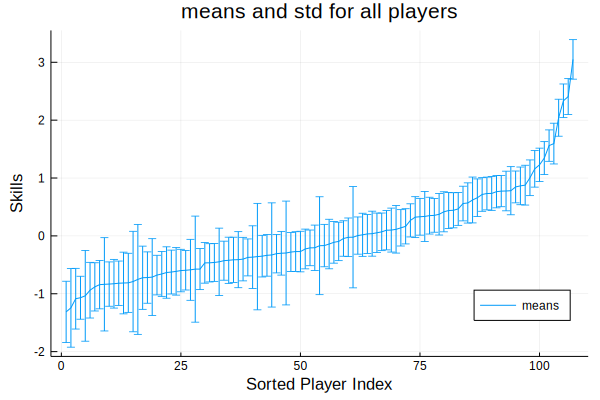

In [25]:
# c. plot mean and std for all players, sorted by skills
means , logstd = fit_variational_dist(tennis_params_init, tennis_games);
means = means[:];
logstd = logstd[:];
plot();
perm = sortperm(means);
plot(means[perm], yerror = exp.(logstd[perm]), title = "means and std for all players",
    xlabel = "Sorted Player Index", ylabel = "Skills", label = "means", legend = :bottomright)

**(d)** List the names of the 10 players with the highest mean skill under the variational model.

In [127]:
# d. List the names of the 10 players with the highest mean skills under the variational model

reverse_perm = sortperm(means, rev = true);
for i in 1:10
    println(player_names[reverse_perm[i]])
end

Novak-Djokovic
Roger-Federer
Rafael-Nadal
Andy-Murray
Robin-Soderling
David-Ferrer
Jo-Wilfried-Tsonga
Tomas-Berdych
Juan-Martin-Del-Potro
Richard-Gasquet


**(e)** Plot the approximate posterior over the skills of Roger Federer and Rafael Nadal. Use the approximate posterior that you fit in question 4 part b.

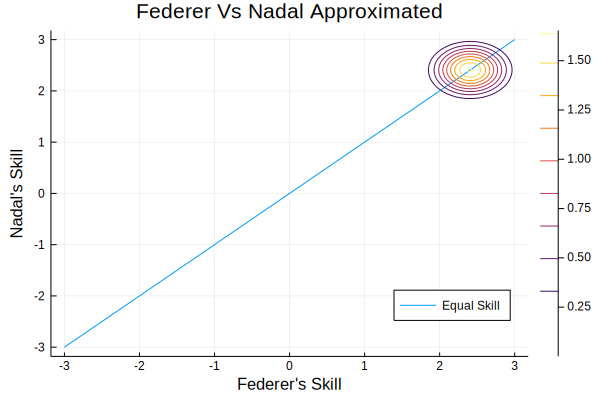

In [27]:
# e. Plot the joint approximate posterior over the skills of Roger Federer and Rafael Nadal.

Federer_index = findall(x -> x=="Roger-Federer" , player_names[:])
Nadal_index = findall(x -> x== "Rafael-Nadal", player_names[:])
plot(title="Federer Vs Nadal Approximated",
    xlabel = "Federer's Skill",
    ylabel = "Nadal's Skill",legend=:bottomright
   )
μ = means[Federer_index, Nadal_index]
σ = exp.(logstd[Federer_index, Nadal_index])
q_estimate(zs) = exp.(factorized_gaussian_log_density(μ, log.(σ), zs))
plot_line_equal_skill!()
skillcontour!(q_estimate )

**(f)** Derive the exact probability under a factorized Gaussian over two players' skills that one has a higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative function of a one-dimensional Gaussian random variable.

**Answer:** $\begin{pmatrix}
z_A \\
z_B
\end{pmatrix}$ $\sim N(\mu , \Sigma)$, we are looking for a linear transform such that 
\begin{align}
A\begin{pmatrix} z_A \\ z_B \end{pmatrix} = \begin{pmatrix} y_A \\ y_B \end{pmatrix} = \begin{pmatrix} z_A - z_B \\ z_B \end{pmatrix}
\end{align}
Solve this equation, we get 
\begin{align}
A &= \begin{pmatrix}1 & -1 \\ 0 & 1 \end{pmatrix} \\
\therefore Y &= \begin{pmatrix}y_A \\ y_B \end{pmatrix} \sim N(A \mu , A\Sigma A^T)\\
Y_1 &= y_A \sim N(\mu_1 , (A\Sigma A^T)_{11}) \\
\because P(z_A > z_B) &= P(z_A - z_B >0) = P(y_A >0) \\
\therefore & = P(\frac{y_A - (A\mu)_1}{(A\Sigma A^T)_{11}} > \frac{-(A\mu)_1}{(A\Sigma A^T)_{11}}) \\
& = 1 - \phi (-\frac{(A\mu)_1}{(A\Sigma A^T)_{11}})
\end{align}

where $\phi$ is the standard normal CDF.

**(g)** Using the formula from part (c), compute the exact probability that your approximate posterior that Roger Federer has higher skill than Rafael Nadal. Then, estimate it using simple Monte Carlo woth 10000 examples, again using your approximate posterior.

In [100]:
# Exact Probability
A = [[1,0] [-1, 1]];
μ_Y = A * means_RF_RN
Σ_Y = exp.(A * logstd_RF_RN * A')
exact_prob = 1 - cdf(Normal(μ_Y[1] , Σ_Y[1]), 0)  #under my approximate posterior

0.7912424380123181

In [169]:
# Monte Carlo Estimation
num_samples = 10000
N = length(means)
ϵ = randn(N, num_samples)  # N*B
samples = exp.(logstd) .* ϵ .+ means ;  # N*B
num_RF_wins = 0
for i in 1:num_samples
    if samples[: , i][Federer_index] > samples[: , i][Nadal_index]
        num_RF_wins = num_RF_wins + 1
    end
    end;
println("Monte Carlo estimated probability that Federer has higher skills than Nadal is ", 
        num_RF_wins / num_samples)

Monte Carlo estimated probability that Federer has higher skills than Nadal is 0.5653


**(h)** Using the formula from part c, compute the probability that Roger Federer is better than the player with the lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples. 

The exact probability that Roger Federer has higher skill than the player with lowest skill is 1. Now let's compute the probability using Monte Carlo:

In [172]:
worst_player = player_names[perm][1]
worst_index = findall(x -> x== worst_player, player_names[:])
ϵ = randn(N, num_samples)  # N*B
samples = exp.(logstd) .* ϵ .+ means ;  # N*B
num_RF_wins = 0
for i in 1:num_samples
    if samples[: , i][Nadal_index] > samples[: , i][worst_index]
        num_RF_wins = num_RF_wins + 1
    end
    end;
println("Monte Carlo estimated probability that Federer has higher skills than the worst player is ", 
        num_RF_wins / num_samples)

Monte Carlo estimated probability that Federer has higher skills than the worst player is 1.0


**(i)** Imagine that we knew ahead of time. that we were examining the skills of top tennis players, and so changed our prior on all players to Normal(10,1). Which answers in this section would this change? No need to show your work, just list the letters of the questions whose answers would ne different in expectation.

**Answer:** (c),(d),(e),(g),(h) will change